In [1]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray
from xeofs.xarray import EOF
import gc
import collections
import statsmodels.api as sm
import scipy
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product
import pyproj
from shapely.geometry import mapping
import pandas as pd
from matplotlib import animation, rc
from IPython.display import HTML, display

In [2]:
plt.rcParams.update({'font.size': 15})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue')

In [3]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
reconstructions_neofs_path = 'reconstructions_neofs/'

In [4]:
# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [5]:
regridded_data = xr.open_dataset(inDirName+regriddedFluxSSH_filepath)
flux = regridded_data.timeMonthly_avg_landIceFreshwaterFlux
ssh = regridded_data.timeMonthly_avg_ssh

In [6]:
# Plot climatology

# Remove climatologies to isolate anomalies / deseasonalize 
flux_month = flux.groupby("time.month")
flux_clm = flux_month.mean("time") # Climatologies
flux_anm = flux_month - flux_clm # Deseasonalized anomalies

# Integrate over entire AIS / basin for time series
flux_clm_ts = flux_clm.sum(['y','x']) # Seasonality / Climatology?
flux_anm_ts = flux_anm.sum(['y','x'], skipna=True)

Text(0.5, 1.0, 'Annual Climatology')

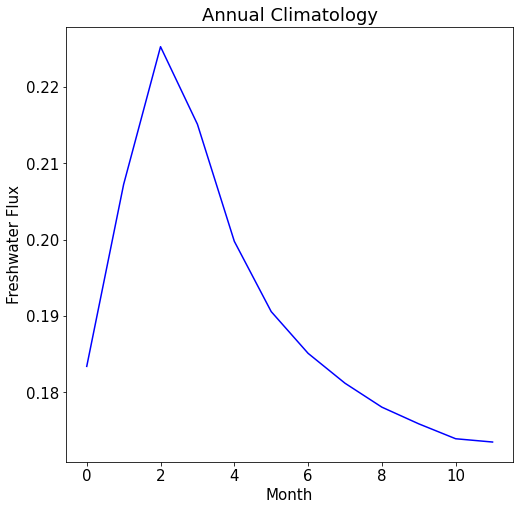

In [7]:
plt.figure(figsize=(8,8))
plt.plot(range(12),flux_clm_ts,color='b') 
plt.ylabel('Freshwater Flux')
plt.xlabel('Month')
plt.title('Annual Climatology')

In [8]:
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

In [9]:
# Plot scatterplot of melt-draft
flux_clean_ts = flux_clean.sum(['y','x'])

Text(0.5, 0, 'Time (months)')

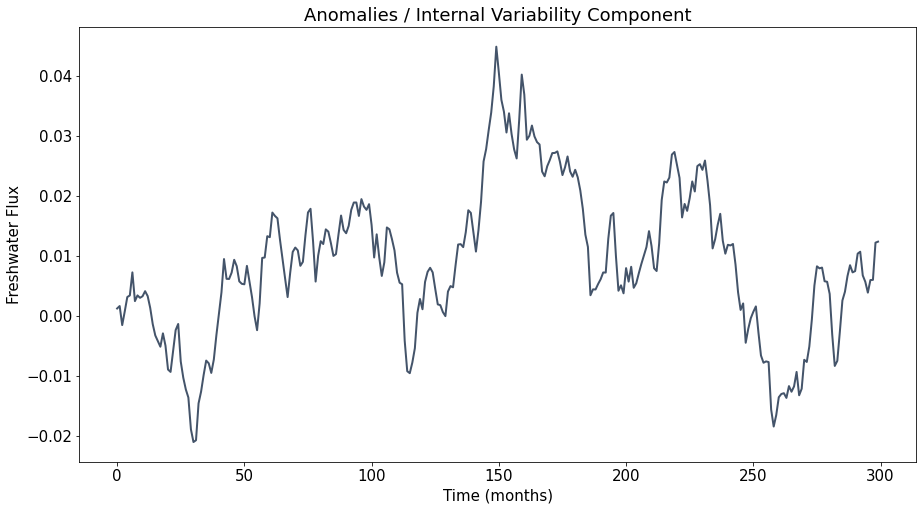

In [151]:
plt.figure(figsize=(15,8))
#plt.plot(flux_anm_ts)
plt.plot(flux_clean_ts[200:500], color = '#44546A', linewidth=2)
plt.title('Internal Variability Component')
plt.ylabel('Freshwater Flux')
plt.xlabel('Time (months)')

In [87]:
basin = 0
basin_flux = flux_clean.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs)
basin_flux = basin_flux.drop("month")
#basin_flux_tmean = basin_flux.mean('time')

In [88]:
%%time
model = EOF(basin_flux)
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()

CPU times: user 33.6 s, sys: 12.5 s, total: 46.1 s
Wall time: 9.39 s


Text(0.5, 1.0, 'Relative Power of EOFs')

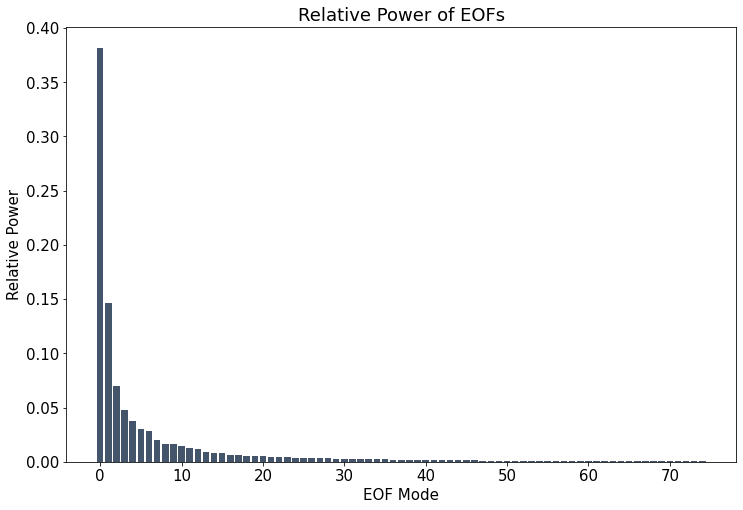

In [89]:
plt.figure(figsize=(12,8))
plt.bar(range(75),varexpl[:75], color='#44546A')
plt.ylabel('Relative Power')
plt.xlabel('EOF Mode')
plt.title('Relative Power of EOFs')

In [94]:
sum(varexpl[:100])

<xarray.DataArray 'explained_variance_ratio' ()>
array(0.98844052)

600

In [65]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(icems.name)

0           Filchner-Ronne
1                     Ross
2               Antarctica
3                Peninsula
4          West Antarctica
5          East Antarctica
6                   IMBIE1
7                   IMBIE2
8                   IMBIE3
9                   IMBIE4
10                  IMBIE5
11                  IMBIE6
12                  IMBIE7
13                  IMBIE8
14                  IMBIE9
15                 IMBIE10
16                 IMBIE11
17                 IMBIE12
18                 IMBIE13
19                 IMBIE14
20                 IMBIE15
21                 IMBIE16
22                 IMBIE17
23                 IMBIE18
24                 IMBIE19
25                 IMBIE20
26                 IMBIE21
27                 IMBIE22
28                 IMBIE23
29                 IMBIE24
30                 IMBIE25
31                 IMBIE26
32                 IMBIE27
33                   Abbot
34                   Amery
35                    Atka
36                 Aviator
3

In [101]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 30
t_length = pcs.shape[0]

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,pcs.shape[0],pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(nmodes):
        fl = pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        #print('calculated ifft for realization i, mode: {}'.format(m))

CPU times: user 11.2 s, sys: 198 ms, total: 11.4 s
Wall time: 11.4 s


In [17]:
#modified to not return f - in calculation of RMSE, only Px required
def psd_calc_grid(data,y,x):
    f, Px = scipy.signal.welch(data[:,y,x])
    return Px

In [18]:
def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

In [79]:
# Reconstruct flux dataset using phase randomized PCs.
# This section is to be called iteratively for ensemble runs with multiple realizations.
# This method also takes 'modes' as a parameter - used to reconstruct dataset with different number of selected modes
def generate_data(mode,mode_skip):
    
    flux_reconstr = model.reconstruct_randomized_X(new_fl[0],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr

In [43]:
def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    clipped_data = clipped_data.drop("month")
    return clipped_data

In [19]:
flux_clean_mean = flux_clean.mean('time')

In [95]:
flux_reconstr = model.reconstruct_randomized_X(new_fl[0],slice(75))

In [103]:
def generate_realizations(n_realization):
    flux_reconstr = model.reconstruct_randomized_X(new_fl[n_realization],slice(75))
    flux_reconstr_ts = flux_reconstr.sum(['y','x'])
    return flux_reconstr_ts

In [105]:
rec_ts_n = np.empty((n_realizations,orig_ts.shape[0]))
for i in range(n_realizations):
    rec_ts_n[i,:] = generate_realizations(i)
    print('reconstructed realization # {}'.format(i))

reconstructed realization # 0
reconstructed realization # 1
reconstructed realization # 2
reconstructed realization # 3
reconstructed realization # 4
reconstructed realization # 5
reconstructed realization # 6
reconstructed realization # 7
reconstructed realization # 8
reconstructed realization # 9
reconstructed realization # 10
reconstructed realization # 11
reconstructed realization # 12
reconstructed realization # 13
reconstructed realization # 14
reconstructed realization # 15
reconstructed realization # 16
reconstructed realization # 17
reconstructed realization # 18
reconstructed realization # 19
reconstructed realization # 20
reconstructed realization # 21
reconstructed realization # 22
reconstructed realization # 23
reconstructed realization # 24
reconstructed realization # 25
reconstructed realization # 26
reconstructed realization # 27
reconstructed realization # 28
reconstructed realization # 29


In [96]:
rec = flux_reconstr
orig = basin_flux

In [113]:
icems.name[0]

'Filchner-Ronne'

In [97]:
orig_ts = time_series(orig)
rec_ts = time_series(rec)

In [107]:
spinuptime = 300/12

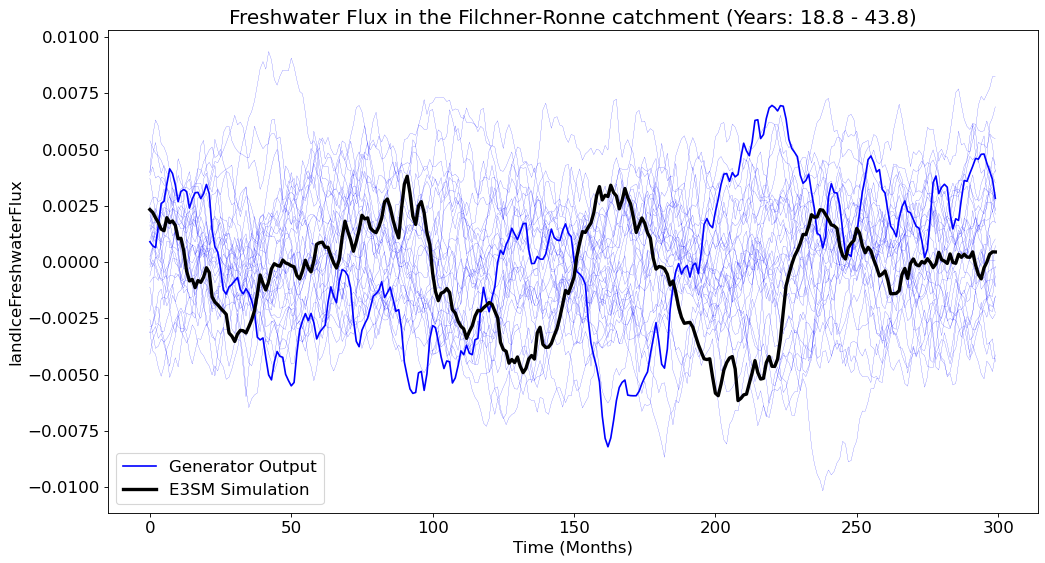

In [161]:
ti = 200
tf = 500

plt.figure(figsize=(15, 8), dpi=80)
for i in range(n_realizations):
    plt.plot(rec_ts_n[i,ti:tf],'b', linewidth=0.15)

plt.plot(rec_ts[ti:tf],'b', linewidth=1.5, label='Generator Output')
#plt.plot(rec_ts_n[15,ti:tf],'b', linewidth=1)
#plt.plot(rec_ts_n[2,ti:tf],'b', linewidth=1)
plt.plot(orig_ts[ti:tf],'k', linewidth=3, label='E3SM Simulation')
#plt.plot(rec_ts_n.mean(0)[ti:tf],'g', linewidth=2)
plt.title('Freshwater Flux in the {} catchment (Years: {:.1f} - {:.1f})'.format(icems.name[basin],(spinuptime+ti)/12,(spinuptime+tf)/12))
plt.ylabel('landIceFreshwaterFlux')
plt.xlabel('Time (Months)')
plt.legend()

(1500,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


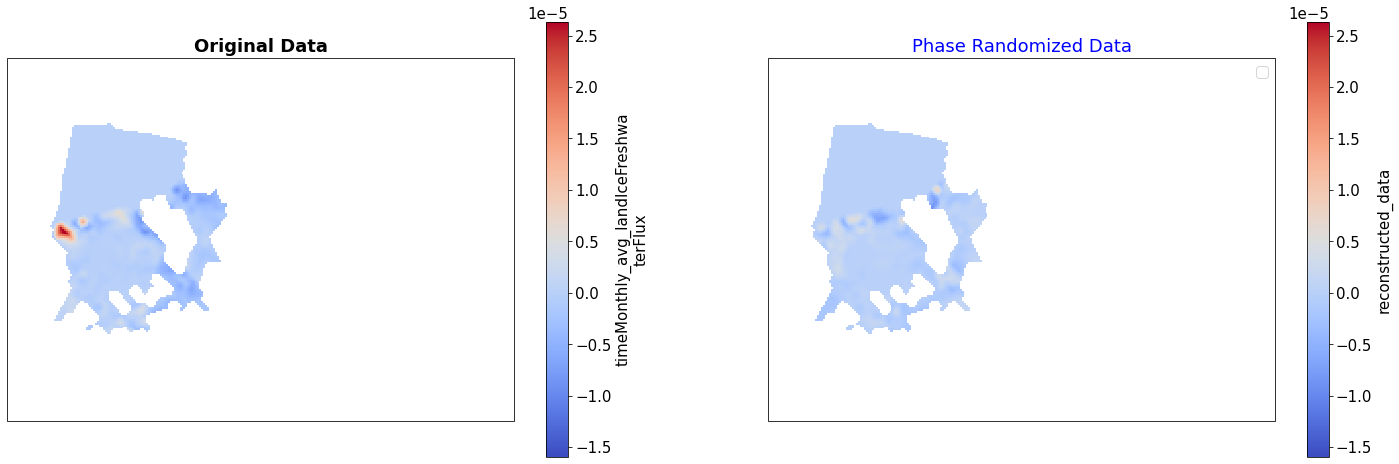

In [98]:
##==================================================
##==============ANIMATION===========================
##==================================================
# Flux trend in time: Contourf animation

# Get a handle on the figure and the axes
fig, axs = plt.subplots(1,2,figsize=(25,8), subplot_kw={'projection': ccrs.SouthPolarStereo()})

vmax = np.nanmax([orig,rec])/2
vmin = np.nanmin([orig,rec])/2

#axs[0, 0].set_title('Axis [0, 0]')

# Plot the initial frame.
# vmin = np.min(flux), vmax = np.max(flux) obtained manually. These should be modified to skip ocean flux values
plt.subplot(121)
cax1 = orig[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm', vmax = vmax, vmin = vmin,
                       cbar_kwargs={'extend':'neither'})
#plt.title("Original Data: " + str(orig_ameryn.coords['time'].values[frame])[:7])
plt.title("Original Data", color= 'black', fontweight='bold')


plt.subplot(122)
cax2 = rec[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm', vmax = vmax, vmin = vmin,
                       cbar_kwargs={'extend':'neither'})
#plt.title("Phase Randomized Data: " + str(rec_ameryn.coords['time'].values[frame])[:7])
plt.title("Phase Randomized Data", color= 'blue')

#plt.subplot(2,2,(3,4))
#cax3, = plt.plot(orig_ts, 'k', linewidth=2, label = 'Original Data')
#cax4, = plt.plot(rec_ts,  'b', linewidth=1, label = 'Phase Randomized Data')

plt.legend()

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax1.set_array(orig[frame,:,:].values.flatten())
    #ax.set_title('Original Simulation')
    cax2.set_array(rec[frame,:,:].values.flatten())
    #ax.set_title("time = " + str(rec_ameryn.coords['time'].values[frame])[:7])
    #fig.set_title('Phase Randomized Emulation')
    #cax3.set_array(orig_ameryn_ts[frame-2:frame+2].values.flatten())
    #cax3.set_array(orig_ameryn[frame].values.flatten())
    #cax3.set_ydata(orig_ts[:frame]) # ANIMATED
    #cax3.set_xdata(range(frame)) # ANIMATED
    #cax3.set_marker('.')
    #cax3.set_markersize(0.25)
    #cax4.set_ydata(rec_ts[:frame])
    #cax4.set_xdata(range(frame))
    #cax4.set_marker('.')
    #cax4.set_markersize(0.25)

# Finally, we use the animation module to create the animation.
ani2 = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=len(orig_ts[:500]),  # Could also be iterable or list
    interval=100     # ms between frames
)

In [100]:
#HTML(ani2.to_jshtml())
ani2.save(inDirName+figures_folderpath+'FRIS_comparison_test.mp4')

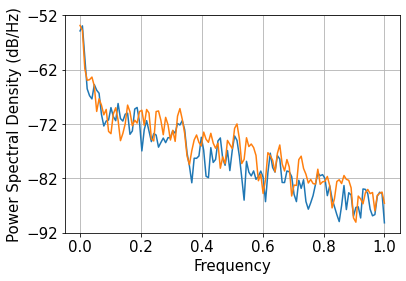

In [86]:
plt.psd(orig_ts);
plt.psd(rec_ts);

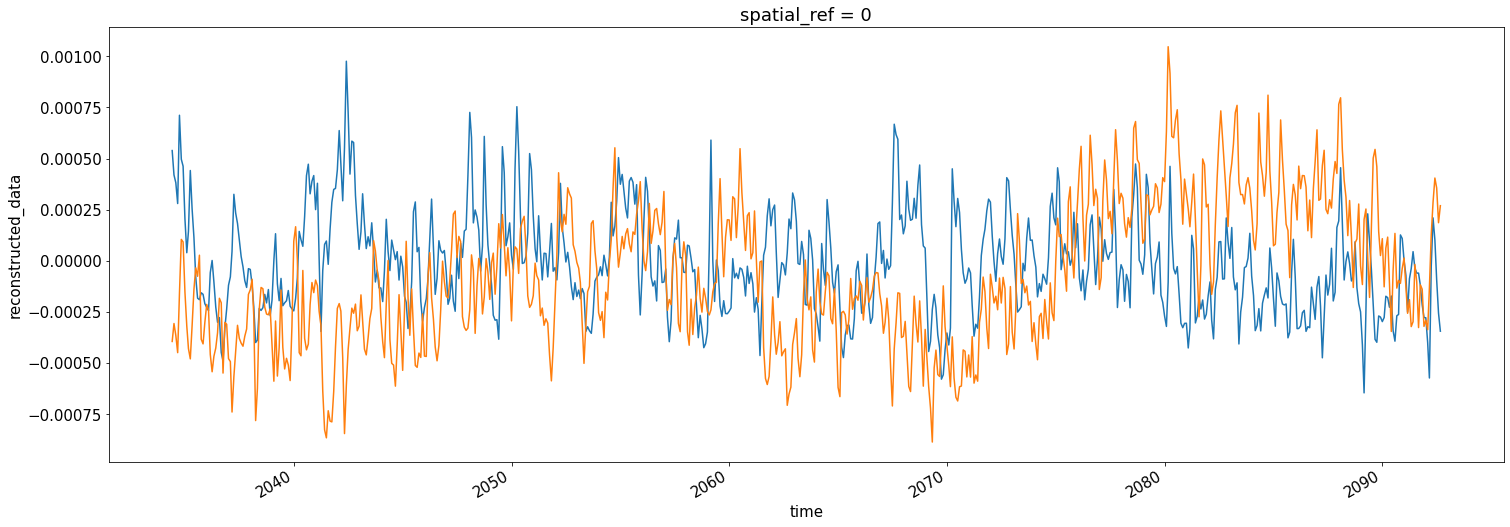

In [85]:
ti = 100
tf = 800

plt.figure(figsize=(25,8))
orig_ts[ti:tf].plot()
rec_ts[ti:tf].plot()

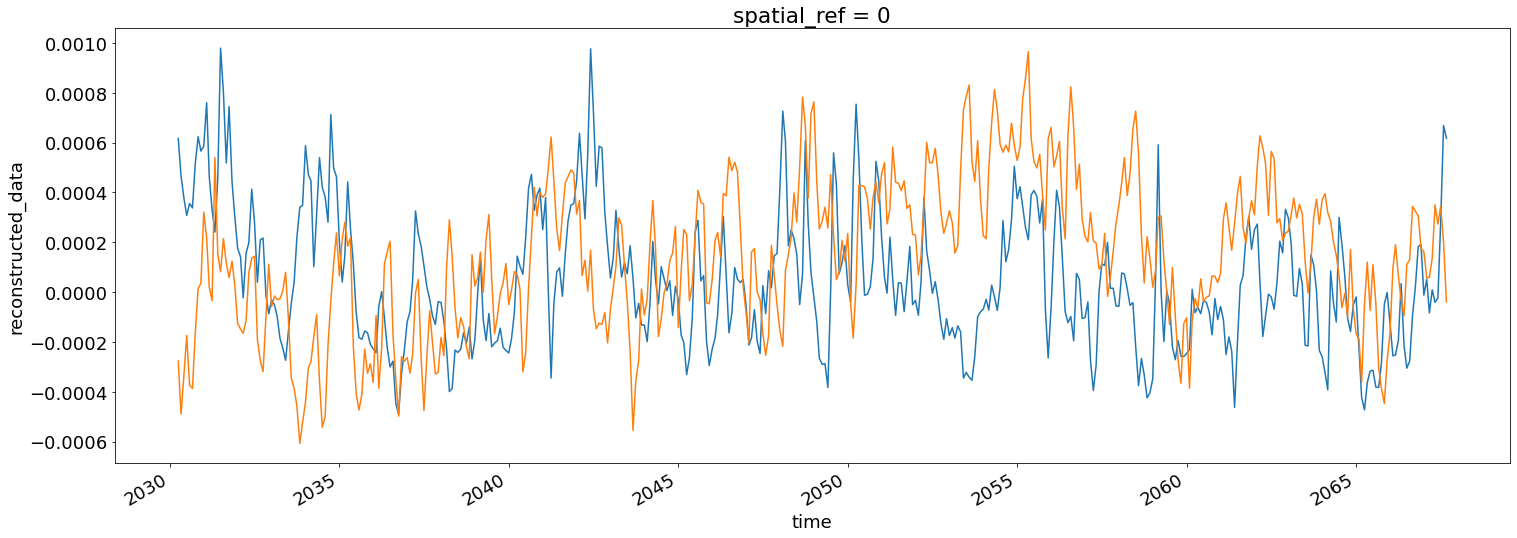

In [129]:
ti = 50
tf = 500

plt.figure(figsize=(25,8))
orig_thw_ts[ti:tf].plot()
rec_thw_ts[ti:tf].plot()